# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [1]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### 1.Set your project path where you have your data and related files for this lab.

In [9]:
!ls
os.chdir('drive/My Drive/AIML/Lab External  Residency 9')

data-20190421T070619Z-001.zip  R9_External_Lab_Questions-2.ipynb  train.zip


FileNotFoundError: ignored

In [0]:
project_path='/content/drive/My Drive/AIML/Lab External  Residency 9/'

### 2. Set the necessary parameters

## Setup

In [0]:
im_width = 128      #width of your train image
im_height = 128     #hight of your train image
#border =        
path_train = project_path + 'train/'   #Path for your train data

# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [18]:
!mkdir lab
!mkdir train

mkdir: cannot create directory ‘lab’: File exists


In [16]:
!ls


data-20190421T070619Z-001.zip  R9_External_Lab_Questions-2.ipynb
lab			       train.zip


# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile(project_path + 'train.zip', 'r') as zf:
  zf.extractall('train/')


In [0]:
#The train file have both images and masks with the same names_ids.

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [0]:
imagelist=os.listdir('/content/drive/My Drive/AIML/Lab External  Residency 9/train/images')
masklist=os.listdir('/content/drive/My Drive/AIML/Lab External  Residency 9/train/masks')

In [25]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

7cc53fe88b.png
7cc53fe88b.png
de08c5a3b7.png
de08c5a3b7.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


In [0]:
import cv2

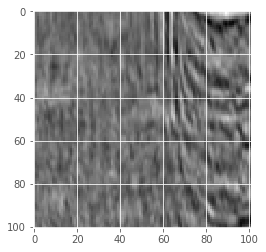

In [28]:
img='/content/drive/My Drive/AIML/Lab External  Residency 9/train/images/'+imagelist[-1]
msk='/content/drive/My Drive/AIML/Lab External  Residency 9/train/masks/'+masklist[-1]

plt.imshow(cv2.imread(img))



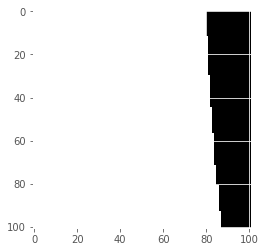

In [29]:
plt.imshow(cv2.imread(msk))

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [45]:
# Get and resize train images and masks
from PIL import Image
def get_data():
    X = np.zeros(((len(imagelist), im_height, im_width, 1)), dtype=np.float32) # Create an array for image
    y = np.zeros(((len(masklist), im_height, im_width, 1)), dtype=np.float32) #Create an array for mask
    
    for n in imagelist: 
        k = imagelist.index(n)
        ##Add image_path
        image_path =  '/content/drive/My Drive/AIML/Lab External  Residency 9/train/images/'+n
        #print (image_path)
        ##Add mask_path
        mask_path ='/content/drive/My Drive/AIML/Lab External  Residency 9/train/masks/'                                                            
        
        # Load images and resize to (128,128,1)
        #/*** Add your code here***/
        img=Image.open(image_path)
        resized_img=img.resize((128,128))
        resized_img=np.reshape(resized_img.convert('L'),(128,128,1))
        
        # Load masks and resize to (128,128,1)
        #/*** Add your code here***/
        m=masklist[k]
        mask_path ='/content/drive/My Drive/AIML/Lab External  Residency 9/train/masks/'+m
        #print(mask_path)
        msk=Image.open(mask_path)
        resized_mask=msk.resize((128,128))
        resized_mask=np.reshape(resized_mask.convert('L'),(128,128,1))
        
        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        y[k] = resized_mask/255
        print('Done!')
    #if train:
        return X, y
    #else:
        #return X
    
X, y = get_data()

Done!


In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

In [48]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)




(3400, 128, 128, 1)
(600, 128, 128, 1)
(3400, 128, 128, 1)
(600, 128, 128, 1)


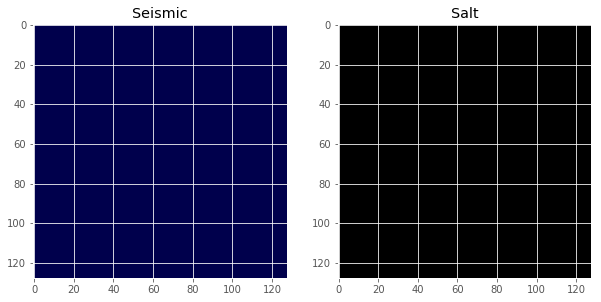

In [52]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');




### 8. Define loss and dice_coeff function.

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.dot(y_true, K.transpose(y_pred))
    union = K.dot(y_true,K.transpose(y_true))+K.dot(y_pred,K.transpose(y_pred))
    return (2. * intersection + smooth) / (union + smooth)





In [0]:
def dice_coef_loss(y_true, y_pred):
    return K.mean(1-dice_coef(y_true, y_pred),axis=-1)

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [0]:
from keras.layers.convolutional import Conv2D, Conv2DTranspose

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
#model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
#compile your model by adding the parameters like optimizer, loss and metrics.
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


In [59]:
#Get the summary of your model
im_width = 128
im_height = 128
border = 5

input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])





Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [60]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [62]:
results = model.fit(X_train, y_train, batch_size=32, epochs=1, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 3400 samples, validate on 600 samples
Epoch 1/1
3400/3400 [==============================] - 15s 4ms/step - loss: 0.5637 - acc: 0.9573 - val_loss: 0.0020 - val_acc: 0.9991

Epoch 00001: val_loss improved from inf to 0.00198, saving model to model-tgs-salt.h5


### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [63]:
preds_val = model.predict(X_valid, verbose=1)

600/600 [==============================] - 1s 1ms/step


In [0]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

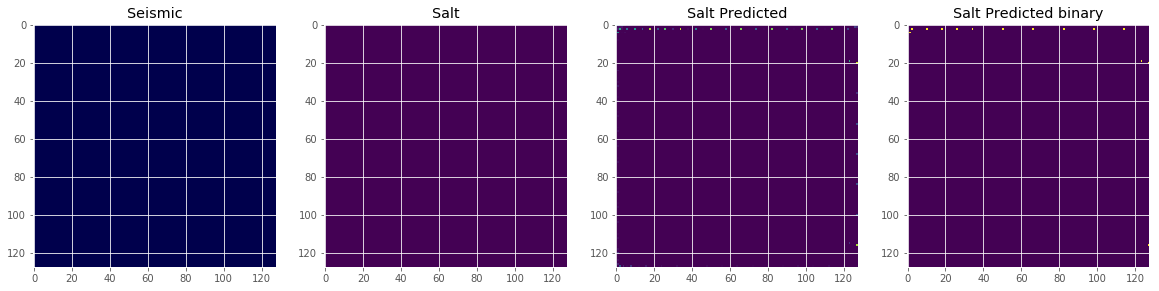

In [66]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.

# Text generation using a RNN

Given a sequence of words from this data, train a model to predict the next word in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

**Mount your Google Drive**

### Import Keras and other libraries

## Download data
Reference: Data is collected from http://www.gutenberg.org

For the lab purpose, you can load the dataset provided by Great Learning

### Load the Oscar Wilde dataset

Store all the ".txt" file names in a list

In [74]:
path='/content/drive/My Drive/AIML/Lab External  Residency 9/data/'

filelist=os.listdir(path)

filelist


['The Duchess of Padua.txt',
 'The Happy Prince and other tales.txt',
 'The Soul of Man.txt',
 'Vera or, The Nihilists.txt',
 'The Canterville Ghost.txt',
 'The Ballad of Reading Gaol.txt',
 'The Picture of Dorian Gray.txt',
 'The Importance of Being Earnest.txt',
 'Shorter Prose Pieces.txt',
 'Selected prose of oscar wilde with a Preface by Robert Ross.txt']

### Read the data

Read contents of every file from the list and append the text in a new list

In [86]:
text=""
for n in filelist:
  
  filepath=path+n
  text = text+open(filepath).read().lower()
  
  
  print (filepath)


/content/drive/My Drive/AIML/Lab External  Residency 9/data/The Duchess of Padua.txt
/content/drive/My Drive/AIML/Lab External  Residency 9/data/The Happy Prince and other tales.txt
/content/drive/My Drive/AIML/Lab External  Residency 9/data/The Soul of Man.txt
/content/drive/My Drive/AIML/Lab External  Residency 9/data/Vera or, The Nihilists.txt
/content/drive/My Drive/AIML/Lab External  Residency 9/data/The Canterville Ghost.txt
/content/drive/My Drive/AIML/Lab External  Residency 9/data/The Ballad of Reading Gaol.txt
/content/drive/My Drive/AIML/Lab External  Residency 9/data/The Picture of Dorian Gray.txt
/content/drive/My Drive/AIML/Lab External  Residency 9/data/The Importance of Being Earnest.txt
/content/drive/My Drive/AIML/Lab External  Residency 9/data/Shorter Prose Pieces.txt
/content/drive/My Drive/AIML/Lab External  Residency 9/data/Selected prose of oscar wilde with a Preface by Robert Ross.txt


## Process the text
Initialize and fit the tokenizer

In [87]:
characters = sorted(list(set(text)))

print('corpus length:', len(text))

print('total chars:', len(characters))

corpus length: 1534084
total chars: 85


In [92]:
maxlen = 40

step = 3

sentences = []

next_chars = []

for i in range(0, len(text) - maxlen, step):
 sentences.append(text[i: i + maxlen])
 next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
char2indices = dict((c, i) for i, c in enumerate(characters))
indices2char = dict((i, c) for i, c in enumerate(characters))

nb sequences: 511348


### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping words to numbers, and another for numbers to words.

In [0]:
X = np.zeros((len(sentences), maxlen, len(characters)), dtype=np.bool)

y = np.zeros((len(sentences), len(characters)), dtype=np.bool)

for i, sentence in enumerate(sentences):
 for t, char in enumerate(sentence):
  X[i, t, char2indices[char]] = 1
  y[i, char2indices[next_chars[i]]] = 1

from keras.models import Sequential

from keras.layers import Dense, LSTM,Activation,Dropout

from keras.optimizers import RMSprop

Get the word count for every word and also get the total number of words.

Convert text to sequence of numbers

### Generate Features and Labels

### The prediction task

Given a word, or a sequence of words, what is the most probable next word? This is the task we're training the model to perform. The input to the model will be a sequence of words, and we train the model to predict the output—the following word at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the words computed until this moment, what is the next word?

### Generate training and testing data

This is just to check the features and labels

## Build The Model

Use `keras.Sequential` to define the model. For this simple example three layers are used to define our model:

* `keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `keras.layers.LSTM`: A type of RNN with size `units=rnn_units` (You can also use a GRU layer here.)
* `keras.layers.Dense`: The output layer, with `num_words` outputs.

In [94]:
model = Sequential()

model.add(LSTM(128, input_shape=(maxlen, len(characters))))

model.add(Dense(len(characters)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))

print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               109568    
_________________________________________________________________
dense_1 (Dense)              (None, 85)                10965     
_________________________________________________________________
activation_19 (Activation)   (None, 85)                0         
Total params: 120,533
Trainable params: 120,533
Non-trainable params: 0
_________________________________________________________________
None


For each word the model looks up the embedding, runs the LSTM one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-liklihood of the next word.

## Train the model

In [0]:
# Function to convert prediction into index

def pred_indices(preds, metric=1.0):

   preds = np.asarray(preds).astype('float64')
   preds = np.log(preds) / metric
   exp_preds = np.exp(preds)
   preds = exp_preds/np.sum(exp_preds)
   probs = np.random.multinomial(1, preds, 1)
   return np.argmax(probs)

In [98]:
import sys
for iteration in range(1, 30):
 print('-' * 40)
 print('Iteration', iteration)
 model.fit(X, y,batch_size=128,epochs=1)
 start_index = random.randint(0, len(text) - maxlen - 1)
 for diversity in [0.2, 0.7,1.2]:
  print('n----- diversity:', diversity)
  generated = ''
  sentence = text[start_index: start_index + maxlen]
  generated += sentence
  print('----- Generating with seed: "' + sentence + '"')
  sys.stdout.write(generated)
  for i in range(400):
   x = np.zeros((1, maxlen, len(characters)))
   for t, char in enumerate(sentence):
    x[0, t, char2indices[char]] = 1.
    preds = model.predict(x, verbose=0)[0]
    next_index = pred_indices(preds, diversity)
    pred_char = indices2char[next_index]
    generated += pred_char
    sentence = sentence[1:] + pred_char
    sys.stdout.write(pred_char)
    sys.stdout.flush()
    print("nOne combination completed n")

----------------------------------------
Iteration 1
Epoch 1/1
511348/511348 [==============================] - 241s 472us/step - loss: 1.5982
n----- diversity: 0.2
----- Generating with seed: "t i have to say.
dorian, from the moment"
t i have to say.
dorian, from the moment.nOne combination completed n
.nOne combination completed n
anOne combination completed n
qnOne combination completed n
 nOne combination completed n
 nOne combination completed n
'nOne combination completed n
.nOne combination completed n
.nOne combination completed n
.nOne combination completed n
.nOne combination completed n
.nOne combination completed n
.nOne combination completed n
.nOne combination completed n
.nOne combination completed n
,nOne combination completed n
.nOne combination completed n
.nOne combination completed n
snOne combination completed n
.nOne combination completed n
.nOne combination completed n
.nOne combination completed n
.nOne combination completed n
.nOne combination completed n
knOn

KeyboardInterrupt: ignored

### Save Model

In [0]:
model.save('rnn_model.h5')

## If you have already trained the model and saved it, you can load a pretrained model

### Note: After loading the model run  model.fit()  to continue training form there, if required.

## Evaluation

## Generate text